In [ ]:
from aggregation_method_reg import run_baselines_and_sacp, run_CSA, run_WAgg, run_SACP_pp
from utilis_def import *

import pandas as pd
import matplotlib.pyplot as plt

openml_ids = [361234, 361235, 361236, 361237, 361242, 361243, 361244, 361247, 361249]

seeds = [
    42, 0, 1, 7, 10,
    13, 17, 19, 23, 29,
    31, 37, 41, 43, 47,
    53, 59, 61, 67, 71
]


alpha, K = 0.05, 255

rows = []

In [ ]:
for dataset_id in openml_ids:
    print(f"\n=== DATASET {dataset_id} ===")
    X, y = load_dataset(dataset_id)

    for seed in seeds:
        print(f"Seed {seed}")
        np.random.seed(seed)
        set_seed(seed)

        X_train, y_train, X_calib, y_calib, X_test, y_test = split_data(
            X, y, random_state=seed
        )

        models = {
            'Linear': LinearRegression(),
            'Lasso': Lasso(alpha=0.1, random_state=42),
            'RandomForest': RandomForestRegressor(
                n_estimators=50, random_state=42,
                min_samples_leaf=max(10, int(X_train.shape[0] * 0.001))
            ),
            'MLP': MLPRegressor(
                hidden_layer_sizes=(10,5),
                learning_rate='adaptive',
                learning_rate_init=0.01,
                max_iter=1000,
                random_state=42
            ),
            'Bayesian': BayesianRidge(),
            'boosttree': HistGradientBoostingRegressor(
                learning_rate=0.1, max_iter=100, max_depth=4,
                min_samples_leaf=max(10, int(X_train.shape[0] * 0.001))
            ),
            'SGDRegressor': SGDRegressor(max_iter=200, tol=1e-3)
        }

        # ===== FIT OF BASE LEARNERS =====
        for model in models.values():
            model.fit(X_train, y_train)
            
        # ---------- BASELINES + SACP + CR + CM ----------
        individual_results, sacp_cov, sacp_len, crc, crl, cmc, cml = run_baselines_and_sacp(
            models, X_calib, y_calib, X_test, y_test, alpha=alpha, K=K
        )

        # ---------- WAGG ----------
        wagg_len, wagg_cov, best_w, best_q = run_WAgg(
            models, X_calib, y_calib, X_test, y_test, alpha=alpha, K=K
        )

        # ---------- CSA ----------
        csa_cov, csa_len = run_CSA(
            models, X_calib, y_calib, X_test, y_test, alpha=alpha, K=K
        )

        # ---------- SACP++ ----------
        p_opt, sacpp_cov, sacpp_len = run_SACP_pp(
            models, X_calib, y_calib, X_test, y_test, alpha=alpha, K=K
        )

        # ======= STORE RESULTS =======
        rows += [
            {'dataset': dataset_id, 'seed': seed, 'method': 'SACP',   'coverage': sacp_cov,  'length': sacp_len},
            {'dataset': dataset_id, 'seed': seed, 'method': 'CR',     'coverage': crc,       'length': crl},
            {'dataset': dataset_id, 'seed': seed, 'method': 'CM',     'coverage': cmc,       'length': cml},
            {'dataset': dataset_id, 'seed': seed, 'method': 'WAGG',   'coverage': wagg_cov,  'length': wagg_len},
            {'dataset': dataset_id, 'seed': seed, 'method': 'CSA',    'coverage': csa_cov,   'length': csa_len},
            {'dataset': dataset_id, 'seed': seed, 'method': 'SACP++', 'coverage': sacpp_cov, 'length': sacpp_len},
        ]

        # ======= BASE LEARNERS =======
        for res in individual_results:
            rows.append({
                'dataset': dataset_id,
                'seed': seed,
                'method': f"Indiv-{res['Model']}",
                'coverage': res['Coverage'],
                'length': res['Avg Length']
            })

        # ======= BL = Best Learner (MIN length) =======
        best_entry = min(individual_results, key=lambda d: d['Avg Length'])
        rows.append({
            'dataset': dataset_id,
            'seed': seed,
            'method': 'BL',
            'coverage': best_entry['Coverage'],
            'length': best_entry['Avg Length']
        })

# DataFrame with all runs
df = pd.DataFrame(rows)

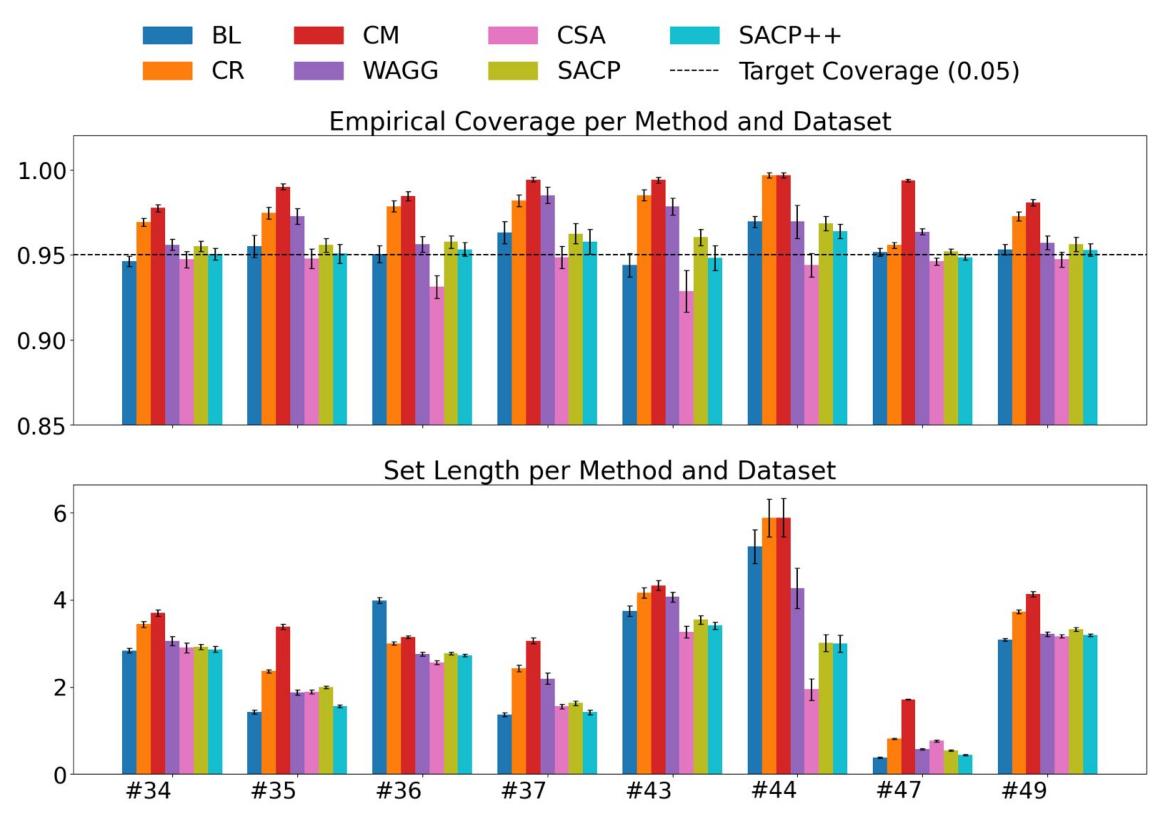

In [ ]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

mpl.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 18
})

methods = ['BL', 'CR', 'CM', 'WAGG', 'CSA', 'SACP', 'SACP++']

colors = {
    'BL': "#1f77b4",
    'CR': "#ff7f0e",
    'CM': "#d62728",
    'WAGG': "#9467bd",
    'CSA': "#e377c2",
    'SACP': "#bcbd22",
    'SACP++': "#17becf"
}

agg = df.groupby(['dataset', 'method']).agg(
    mean_cov=('coverage', 'mean'),
    sem_cov=('coverage', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
    mean_len=('length', 'mean'),
    sem_len=('length', lambda x: x.std(ddof=1) / np.sqrt(len(x)))
).reset_index()

datasets = agg['dataset'].unique()
x = np.arange(len(datasets))

n_m = len(methods)
total_w = 0.80
bw = total_w / n_m
start = -total_w / 2 + bw / 2

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Coverage
for i, m in enumerate(methods):
    means, sems = [], []
    for d in datasets:
        r = agg[(agg.dataset == d) & (agg.method == m)]
        means.append(r.mean_cov.values[0] if not r.empty else np.nan)
        sems.append(r.sem_cov.values[0] if not r.empty else np.nan)

    offsets = x + start + i * bw
    upper = np.minimum(np.array(means) + np.array(sems), 1.0)
    lower = np.array(means) - np.array(sems)

    axes[0].bar(
        offsets, means, bw,
        yerr=[np.array(means) - lower, upper - np.array(means)],
        capsize=3,
        color=colors[m],
        label=m
    )

axes[0].axhline(alpha, color='black', linestyle='--', linewidth=1.5)
axes[0].set_ylim(0.85, 1.02)
axes[0].set_title("Empirical Coverage per Method and Dataset")

# Length
for i, m in enumerate(methods):
    means, sems = [], []
    for d in datasets:
        r = agg[(agg.dataset == d) & (agg.method == m)]
        means.append(r.mean_len.values[0] if not r.empty else np.nan)
        sems.append(r.sem_len.values[0] if not r.empty else np.nan)

    offsets = x + start + i * bw
    axes[1].bar(
        offsets, means, bw,
        yerr=sems,
        capsize=3,
        color=colors[m]
    )

axes[1].set_title("Set Length per Method and Dataset")
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets, rotation=45, ha='right')

handles = [mpatches.Patch(color=colors[m], label=m) for m in methods]
handles.append(mlines.Line2D([], [], color='black', linestyle='--',
                             label=f"Target Coverage ({alpha:.2f})"))

fig.legend(handles=handles, loc='upper center',
           bbox_to_anchor=(0.5, 1.02), ncol=4, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()
